This doc will be used for research purposes to try to see if we can propose a way to backtest a certain a bot that. The code will also go over the analysis of the current way backtesting takes place and how training models performe against some of the commenly used stratagies. 

In [36]:
# imports
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import ccxt

### Gathering the information ###
I want to make it so that we can use historic data and not need to download the data each time.

In [37]:
# Define the ticker symbol
ticker_symbol = 'NVDA'
data_file_path = f"./data/{ticker_symbol}_data.csv"

if os.path.exists(data_file_path):
    data = pd.read_csv(data_file_path, index_col=0, parse_dates=True)
else:
    # Get the ticker object
    ticker = yf.Ticker(ticker_symbol)

    # Get historical market data (here, we get the last 1 month of data)('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    data = ticker.history(period="1d", start="2010-01-01", end="2020-12-31")
    # data = ticker.history(start="2020-01-01", end="2020-12-31")

    os.makedirs(os.path.dirname(data_file_path), exist_ok=True)
    data.to_csv(data_file_path)

C:\Users\sahit\AppData\Local\Temp\ipykernel_16052\3797234344.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Signal"][short_window:] = np.where(


                               Open      High       Low     Close     Volume  \
Date                                                                           
2010-01-04 00:00:00-05:00  0.424447  0.426969  0.415274  0.423988  800204000   
2010-01-05 00:00:00-05:00  0.422383  0.434766  0.422383  0.430179  728648000   
2010-01-06 00:00:00-05:00  0.429950  0.433848  0.425822  0.432931  649168000   
2010-01-07 00:00:00-05:00  0.430638  0.432472  0.421236  0.424447  547792000   
2010-01-08 00:00:00-05:00  0.421007  0.428345  0.418485  0.425364  478168000   

                           Dividends  Stock Splits  Short_MA   Long_MA  \
Date                                                                     
2010-01-04 00:00:00-05:00        0.0           0.0  0.423988  0.423988   
2010-01-05 00:00:00-05:00        0.0           0.0  0.427084  0.427084   
2010-01-06 00:00:00-05:00        0.0           0.0  0.429033  0.429033   
2010-01-07 00:00:00-05:00        0.0           0.0  0.427886  0.42788

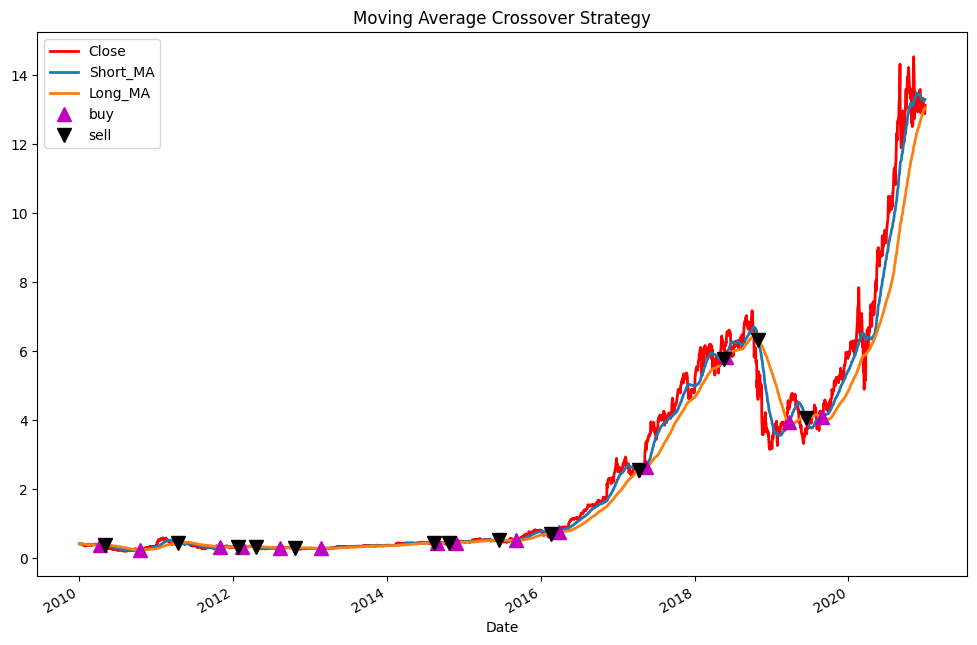

Total return: 1.17%
Annualized return: 0.11%


In [38]:

# Define the moving average periods
short_window = 40
long_window = 100

# Generate signals
data["Short_MA"] = (
    data["Close"].rolling(window=short_window, min_periods=1, center=False).mean()
)
data["Long_MA"] = (
    data["Close"].rolling(window=long_window, min_periods=1, center=False).mean()
)
data["Signal"] = 0.0
data["Signal"][short_window:] = np.where(
    data["Short_MA"][short_window:] > data["Long_MA"][short_window:], 1.0, 0.0
)
data["Position"] = data["Signal"].diff()

# Print the data with signals
print(data.head())

# Backtest the strategy
initial_capital = 10000.0  # Initial capital in USD
shares = 10  # Number of shares to trade
positions = pd.DataFrame(index=data.index).fillna(0.0)
positions["AAPL"] = shares * data["Signal"]  # Buy a fixed number of shares

portfolio = positions.multiply(data["Close"], axis=0)
pos_diff = positions.diff()

portfolio["Holdings"] = (positions.multiply(data["Close"], axis=0)).sum(axis=1)
portfolio["Cash"] = (
    initial_capital - (pos_diff.multiply(data["Close"], axis=0)).sum(axis=1).cumsum()
)
portfolio["Total"] = portfolio["Cash"] + portfolio["Holdings"]
portfolio["Returns"] = portfolio["Total"].pct_change()

# Print portfolio
print(portfolio.head())

# Plot the strategy
fig, ax = plt.subplots(figsize=(12, 8))

data["Close"].plot(ax=ax, color="r", lw=2.0)
data[["Short_MA", "Long_MA"]].plot(ax=ax, lw=2.0)

ax.plot(
    data.loc[data["Position"] == 1.0].index,
    data["Short_MA"][data["Position"] == 1.0],
    "^",
    markersize=10,
    color="m",
    label="buy",
)

ax.plot(
    data.loc[data["Position"] == -1.0].index,
    data["Short_MA"][data["Position"] == -1.0],
    "v",
    markersize=10,
    color="k",
    label="sell",
)

plt.title("Moving Average Crossover Strategy")
plt.legend()
plt.show()

# Evaluate performance
total_return = portfolio["Total"][-1] / initial_capital - 1.0
annualized_return = (1 + total_return) ** (252 / len(portfolio)) - 1
print(f"Total return: {total_return:.2%}")
print(f"Annualized return: {annualized_return:.2%}")

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt



# Calculate moving averages
data["SMA50"] = data["Close"].rolling(window=50).mean()
data["SMA200"] = data["Close"].rolling(window=200).mean()

# Initialize variables
position = None  # No position initially
entry_price = 0
profit = 0
cumulative_returns = []

# Trading strategy: Simple Moving Average (SMA) Crossover
for index, row in data.iterrows():
    if row["SMA50"] > row["SMA200"] and position != "long":
        # Close short position if any
        if position == "short":
            profit += entry_price - row["Close"]

        # Open long position
        position = "long"
        entry_price = row["Close"]

    elif row["SMA50"] < row["SMA200"] and position != "short":
        # Close long position if any
        if position == "long":
            profit += row["Close"] - entry_price

        # Open short position
        position = "short"
        entry_price = row["Close"]

    # cumulative_returns.append(profit)

# Final position handling at the end of the data
if position == "long":
    profit += data.iloc[-1]["Close"] - entry_price
elif position == "short":
    profit += entry_price - data.iloc[-1]["Close"]

cumulative_returns.append(profit)

# Adjust lengths of cumulative_returns and data.index
if len(cumulative_returns) < len(data):
    cumulative_returns.append(cumulative_returns[-1])
    
print(cumulative_returns)

# Plot cumulative returns
# plt.figure(figsize=(10, 6))
# plt.plot(
#     data.index, cumulative_returns[: len(data)], label="Cumulative Returns", color="b"
# )
# plt.title("Cumulative Returns Over Time")
# plt.xlabel("Date")
# plt.ylabel("Cumulative Returns")
# plt.legend()
# plt.grid(True)
# plt.show()

[13.818288385868073, 13.818288385868073]
